<a href="https://colab.research.google.com/github/rename-z/Deep-Learning/blob/master/Zero%20to%20GANs/Feed%20Forward%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Training Deep Neural Networks on a GPU with PyTorch**

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [7]:
dataset = MNIST(root='/content', download=True, transform=ToTensor())

In [8]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [9]:
batch_size = 128

In [10]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


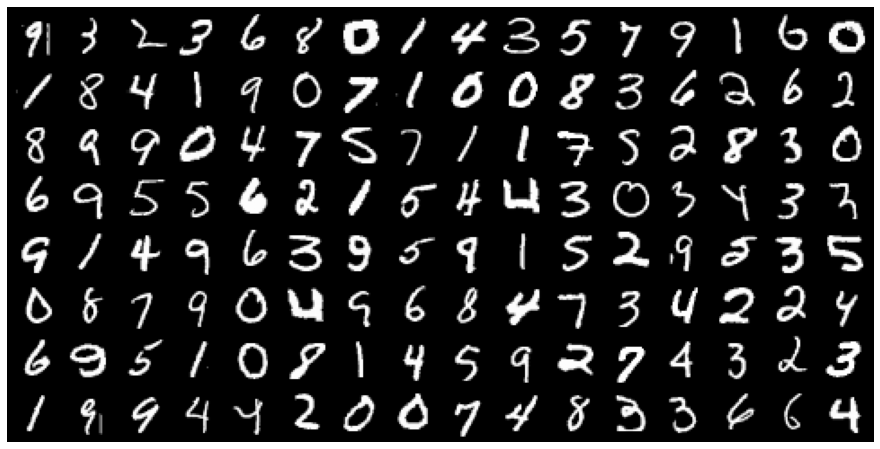

In [13]:
for images, _ in train_loader :
  print('images.shape:',images.shape)
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [14]:
def accuracy(outputs, labels) :
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class MnistModel(nn.Module) :
  """Feed Forward Neural Network with 1 hidden layer"""
  def __init__(self, in_features, hidden_size, out_features) :
    super().__init__()
    self.linear1 = nn.Linear(in_features, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_features)

  def forward(self, xb) :
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self, batch) :
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  
  def validation_step(self, batch) :
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs) :
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result) :
    print(f'Epoch [{epoch}], val_loss : {result["val_loss"]:.4f}, val_acc : {result["val_acc"]:.4f}') 

In [18]:
in_features = 1*28*28
hidden_size = 32
out_features = 10

In [21]:
model = MnistModel(in_features, hidden_size, out_features)

In [22]:
for t in model.parameters() :
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [23]:
for images, labels in train_loader :
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('loss : ', loss)
  break

print('outputs shape : ', outputs.shape)
print('outputs : \n', outputs[:2])

loss :  tensor(2.3184, grad_fn=<NllLossBackward>)
outputs shape :  torch.Size([128, 10])
outputs : 
 tensor([[-0.1001, -0.0669, -0.0124,  0.0712,  0.1632,  0.0225, -0.0451,  0.0334,
         -0.1036,  0.1479],
        [-0.1629, -0.0337,  0.0117,  0.1642,  0.2562, -0.0630, -0.0195,  0.1035,
         -0.1987,  0.2339]], grad_fn=<SliceBackward>)


### *Using GPU*

In [24]:
torch.cuda.is_available()

False